In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression


In [63]:
hpi_index = pd.read_csv("/Users/julius/Personal/Personal_Project/House_market_analysis/Global-Housing-Market-Analysis/Dataset/global_housing_market_extended.csv")

In [64]:
hpi_index

,Country,Year,House Price Index,Rent Index,Affordability Ratio,Mortgage Rate (%),Inflation Rate (%),GDP Growth (%),Population Growth (%),Urbanization Rate (%),Construction Index
0,USA,2015,117.454012,116.550001,9.587945,4.493292,1.514121,-0.752044,-0.796707,85.985284,118.089201
1,USA,2016,150.807258,51.440915,11.729189,5.662213,1.880204,-0.545400,-0.358084,69.127267,111.980515
2,USA,2017,123.194502,70.386040,8.506676,2.197469,2.398940,0.930895,0.596245,83.555279,85.973903
3,USA,2018,131.423444,91.469020,3.418054,4.537724,1.608407,-1.479587,2.321099,88.968961,134.671788
4,USA,2019,110.461377,56.837048,9.158097,3.700762,1.293249,1.961415,-0.879640,87.279612,90.702399
...,...,...,...,...,...,...,...,...,...,...,...
195,UAE,2020,160.153711,117.170365,7.390686,2.048681,4.061737,1.635019,1.955250,62.942477,109.059291
196,UAE,2021,95.004866,72.727315,9.636214,3.880091,2.943274,1.155810,0.608064,83.550496,141.366775
197,UAE,2022,175.533469,105.083237,5.838662,4.940674,3.344420,0.037365,1.943051,61.152790,142.140959
198,UAE,2023,126.147746,94.604103,8.934185,5.975589,4.638353,2.911469,-0.766718,75.552241,82.013520


In [65]:
hpi_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                200 non-null    object 
 1   Year                   200 non-null    int64  
 2   House Price Index      200 non-null    float64
 3   Rent Index             200 non-null    float64
 4   Affordability Ratio    200 non-null    float64
 5   Mortgage Rate (%)      200 non-null    float64
 6   Inflation Rate (%)     200 non-null    float64
 7   GDP Growth (%)         200 non-null    float64
 8   Population Growth (%)  200 non-null    float64
 9   Urbanization Rate (%)  200 non-null    float64
 10  Construction Index     200 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 17.3+ KB


In [66]:
hpi_index.describe()

,Year,House Price Index,Rent Index,Affordability Ratio,Mortgage Rate (%),Inflation Rate (%),GDP Growth (%),Population Growth (%),Urbanization Rate (%),Construction Index
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2019.500000,130.381022,83.048370,7.237768,4.150621,3.649756,2.133722,0.722806,74.769891,111.204257
std,2.879489,28.752229,21.439858,2.576085,1.380222,1.881938,2.413270,1.035691,8.734246,24.309473
min,2015.000000,80.552212,50.354311,3.041688,1.537814,0.532110,-1.921833,-0.961391,60.172760,70.968678
25%,2017.000000,104.142562,60.466671,5.034207,3.045278,1.939199,-0.095628,-0.183320,66.923842,90.182198
50%,2019.500000,129.193653,83.721711,7.375697,4.329643,3.664625,2.307548,0.722372,75.100060,110.593807
75%,2022.000000,157.127098,100.604665,9.276196,5.217706,5.261720,4.272776,1.621317,82.677430,133.780445
max,2024.000000,179.971767,119.855388,11.879671,6.485623,6.912349,5.958931,2.497948,89.788944,149.735748


In [67]:
#Feature engineering
hpi_index['Year_num'] = hpi_index['Year']
hpi_index['HPI_lag_1'] = hpi_index.groupby('Country')['House Price Index'].shift(1)
hpi_index['HPI_lag_2'] = hpi_index.groupby('Country')['House Price Index'].shift(2)
hpi_index['HPI_roll_mean_3'] = hpi_index.groupby('Country')['House Price Index'].rolling(3).mean().reset_index(0, drop=True)
hpi_index['HPI_roll_std_3'] = hpi_index.groupby('Country')['House Price Index'].rolling(3).std().reset_index(0, drop=True)

#more feature engineering
hpi_index['Period'] = hpi_index['Year'].apply(lambda x: 'Pre-COVID' if x <= 2019 else 'Post-COVID')
hpi_index['Economic_Stress'] = hpi_index['Inflation Rate (%)'] + hpi_index['Mortgage Rate (%)'] - hpi_index['GDP Growth (%)']


In [68]:
hpi_index

,Country,Year,House Price Index,Rent Index,Affordability Ratio,Mortgage Rate (%),Inflation Rate (%),GDP Growth (%),Population Growth (%),Urbanization Rate (%),Construction Index,Year_num,HPI_lag_1,HPI_lag_2,HPI_roll_mean_3,HPI_roll_std_3,Period,Economic_Stress
0,USA,2015,117.454012,116.550001,9.587945,4.493292,1.514121,-0.752044,-0.796707,85.985284,118.089201,2015,NaN,NaN,NaN,NaN,Pre-COVID,6.759457
1,USA,2016,150.807258,51.440915,11.729189,5.662213,1.880204,-0.545400,-0.358084,69.127267,111.980515,2016,117.454012,NaN,NaN,NaN,Pre-COVID,8.087818
2,USA,2017,123.194502,70.386040,8.506676,2.197469,2.398940,0.930895,0.596245,83.555279,85.973903,2017,150.807258,117.454012,130.485257,17.831884,Pre-COVID,3.665515
3,USA,2018,131.423444,91.469020,3.418054,4.537724,1.608407,-1.479587,2.321099,88.968961,134.671788,2018,123.194502,150.807258,135.141734,14.176930,Pre-COVID,7.625718
4,USA,2019,110.461377,56.837048,9.158097,3.700762,1.293249,1.961415,-0.879640,87.279612,90.702399,2019,131.423444,123.194502,121.693108,10.561378,Pre-COVID,3.032596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,UAE,2020,160.153711,117.170365,7.390686,2.048681,4.061737,1.635019,1.955250,62.942477,109.059291,2020,81.919228,99.462251,113.845063,41.052498,Post-COVID,4.475399
196,UAE,2021,95.004866,72.727315,9.636214,3.880091,2.943274,1.155810,0.608064,83.550496,141.366775,2021,160.153711,81.919228,112.359268,41.905132,Post-COVID,5.667554
197,UAE,2022,175.533469,105.083237,5.838662,4.940674,3.344420,0.037365,1.943051,61.152790,142.140959,2022,95.004866,160.153711,143.564015,42.750760,Post-COVID,8.247729
198,UAE,2023,126.147746,94.604103,8.934185,5.975589,4.638353,2.911469,-0.766718,75.552241,82.013520,2023,175.533469,95.004866,132.228694,40.607233,Post-COVID,7.702473


Since there are Nan value I'm going to use mean to filled in the NaN Value

In [69]:
hpi_index['HPI_lag_1'] = hpi_index['HPI_lag_1'].fillna(hpi_index['House Price Index'].shift(1).mean())
hpi_index['HPI_lag_2'] = hpi_index['HPI_lag_2'].fillna(hpi_index['House Price Index'].shift(2).mean())
hpi_index['HPI_roll_mean_3'] = hpi_index['HPI_roll_mean_3'].fillna(hpi_index['House Price Index'].rolling(3).mean().mean())
hpi_index['HPI_roll_std_3'] = hpi_index['HPI_roll_std_3'].fillna(hpi_index['House Price Index'].rolling(3).std().mean())

In [70]:
hpi_index = pd.get_dummies(hpi_index, columns=['Period'], drop_first=True)

In [71]:
hpi_index

,Country,Year,House Price Index,Rent Index,Affordability Ratio,Mortgage Rate (%),Inflation Rate (%),GDP Growth (%),Population Growth (%),Urbanization Rate (%),Construction Index,Year_num,HPI_lag_1,HPI_lag_2,HPI_roll_mean_3,HPI_roll_std_3,Economic_Stress,Period_Pre-COVID
0,USA,2015,117.454012,116.550001,9.587945,4.493292,1.514121,-0.752044,-0.796707,85.985284,118.089201,2015,130.263623,130.284411,130.318625,26.067870,6.759457,True
1,USA,2016,150.807258,51.440915,11.729189,5.662213,1.880204,-0.545400,-0.358084,69.127267,111.980515,2016,117.454012,130.284411,130.318625,26.067870,8.087818,True
2,USA,2017,123.194502,70.386040,8.506676,2.197469,2.398940,0.930895,0.596245,83.555279,85.973903,2017,150.807258,117.454012,130.485257,17.831884,3.665515,True
3,USA,2018,131.423444,91.469020,3.418054,4.537724,1.608407,-1.479587,2.321099,88.968961,134.671788,2018,123.194502,150.807258,135.141734,14.176930,7.625718,True
4,USA,2019,110.461377,56.837048,9.158097,3.700762,1.293249,1.961415,-0.879640,87.279612,90.702399,2019,131.423444,123.194502,121.693108,10.561378,3.032596,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,UAE,2020,160.153711,117.170365,7.390686,2.048681,4.061737,1.635019,1.955250,62.942477,109.059291,2020,81.919228,99.462251,113.845063,41.052498,4.475399,False
196,UAE,2021,95.004866,72.727315,9.636214,3.880091,2.943274,1.155810,0.608064,83.550496,141.366775,2021,160.153711,81.919228,112.359268,41.905132,5.667554,False
197,UAE,2022,175.533469,105.083237,5.838662,4.940674,3.344420,0.037365,1.943051,61.152790,142.140959,2022,95.004866,160.153711,143.564015,42.750760,8.247729,False
198,UAE,2023,126.147746,94.604103,8.934185,5.975589,4.638353,2.911469,-0.766718,75.552241,82.013520,2023,175.533469,95.004866,132.228694,40.607233,7.702473,False


In [61]:
X = hpi_index[features]
y = hpi_index[target]

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

# View scores and p-values
feature_scores = pd.DataFrame({
    'Feature': features,
    'F-Score': selector.scores_,
    'P-Value': selector.pvalues_
}).sort_values(by='F-Score', ascending=False)

print(feature_scores)

                  Feature    F-Score       P-Value
8         HPI_roll_mean_3  70.409420  9.049225e-15
10        Economic_Stress   3.114602  7.913511e-02
1              Rent Index   1.931136  1.661948e-01
3          GDP Growth (%)   1.294063  2.566753e-01
11       Period_Pre-COVID   1.193306  2.759911e-01
2   Population Growth (%)   1.179173  2.788448e-01
4       Mortgage Rate (%)   0.967729  3.264479e-01
7               HPI_lag_2   0.824828  3.648763e-01
6               HPI_lag_1   0.547319  4.602917e-01
5      Inflation Rate (%)   0.502771  4.791194e-01
9          HPI_roll_std_3   0.326415  5.684257e-01
0                    Year   0.269876  6.039954e-01


In [76]:
#defining features and target
features = ['Year',"Rent Index",'HPI_roll_mean_3']
target = 'House Price Index'

In [77]:
#train Test Split
X = hpi_index[features]
y = hpi_index[target]

X_train = X[X['Year'] <= 2020]
X_test = X[X['Year'] > 2020]
y_train = y[X['Year'] <= 2020]
y_test = y[X['Year'] > 2020]

In [78]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [79]:
y_pred = model.predict(X_test)

In [80]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 19.92872400137565
RMSE: 23.60619421279868


In [81]:
#train testing again for xgboost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
model = XGBRegressor(n_estimators = 100, max_depth = 3, learning_rate = 0.1,objective='reg:squarederror')
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [83]:
X_train

,Year,Rent Index,HPI_roll_mean_3
79,2024,83.010333,119.155092
197,2022,105.083237,143.564015
38,2023,80.369615,121.471326
24,2019,102.254398,142.532930
122,2017,74.508768,139.920040
...,...,...,...
106,2021,76.819697,94.938568
14,2019,110.251141,121.112766
92,2017,81.655256,148.584656
179,2024,87.307045,112.721447


In [84]:
y_pred = model.predict(X_test)


In [85]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")

RMSE: 27.34


In [86]:
#Gridsearch to improve the result
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [2, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
grid = GridSearchCV(xgb, param_grid=params, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

xgb = XGBRegressor(random_state=42)
grid = GridSearchCV(xgb, param_grid=params, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [2, 3, 5], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error')

In [87]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Best Parameters: {grid.best_params_}")
print(f"Test RMSE: {rmse:.2f}")

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}
Test RMSE: 26.88


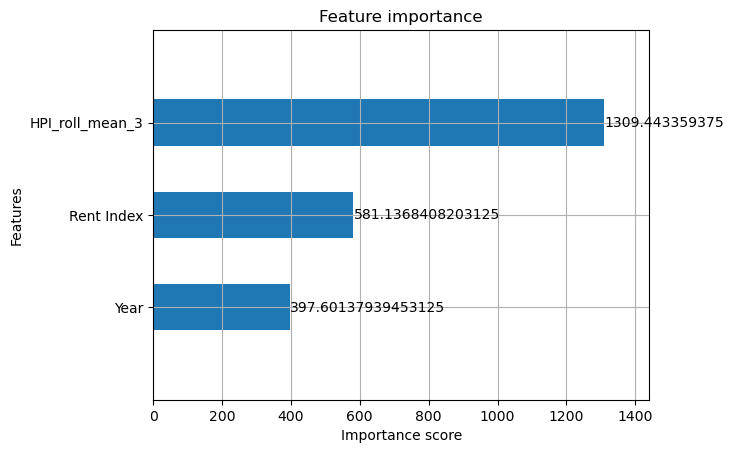

In [88]:
plot_importance(model, height=0.5, importance_type='gain', max_num_features=10)
plt.show()

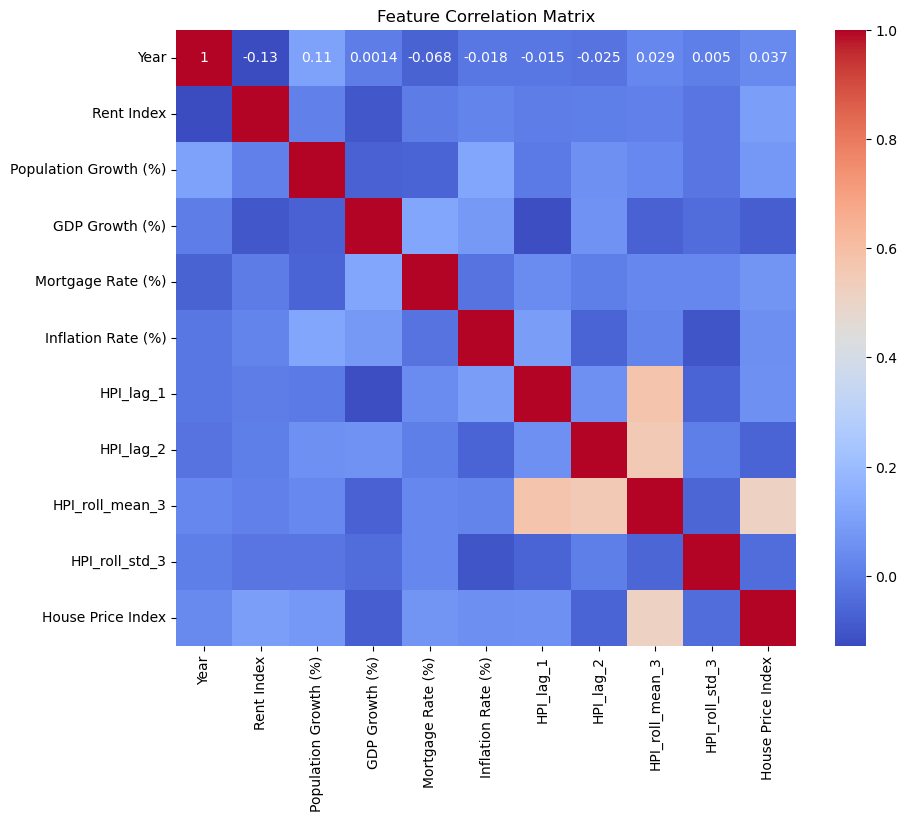

In [41]:
corr_matrix = hpi_index[features + [target]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [89]:
hpi_index


,Country,Year,House Price Index,Rent Index,Affordability Ratio,Mortgage Rate (%),Inflation Rate (%),GDP Growth (%),Population Growth (%),Urbanization Rate (%),Construction Index,Year_num,HPI_lag_1,HPI_lag_2,HPI_roll_mean_3,HPI_roll_std_3,Economic_Stress,Period_Pre-COVID
0,USA,2015,117.454012,116.550001,9.587945,4.493292,1.514121,-0.752044,-0.796707,85.985284,118.089201,2015,130.263623,130.284411,130.318625,26.067870,6.759457,True
1,USA,2016,150.807258,51.440915,11.729189,5.662213,1.880204,-0.545400,-0.358084,69.127267,111.980515,2016,117.454012,130.284411,130.318625,26.067870,8.087818,True
2,USA,2017,123.194502,70.386040,8.506676,2.197469,2.398940,0.930895,0.596245,83.555279,85.973903,2017,150.807258,117.454012,130.485257,17.831884,3.665515,True
3,USA,2018,131.423444,91.469020,3.418054,4.537724,1.608407,-1.479587,2.321099,88.968961,134.671788,2018,123.194502,150.807258,135.141734,14.176930,7.625718,True
4,USA,2019,110.461377,56.837048,9.158097,3.700762,1.293249,1.961415,-0.879640,87.279612,90.702399,2019,131.423444,123.194502,121.693108,10.561378,3.032596,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,UAE,2020,160.153711,117.170365,7.390686,2.048681,4.061737,1.635019,1.955250,62.942477,109.059291,2020,81.919228,99.462251,113.845063,41.052498,4.475399,False
196,UAE,2021,95.004866,72.727315,9.636214,3.880091,2.943274,1.155810,0.608064,83.550496,141.366775,2021,160.153711,81.919228,112.359268,41.905132,5.667554,False
197,UAE,2022,175.533469,105.083237,5.838662,4.940674,3.344420,0.037365,1.943051,61.152790,142.140959,2022,95.004866,160.153711,143.564015,42.750760,8.247729,False
198,UAE,2023,126.147746,94.604103,8.934185,5.975589,4.638353,2.911469,-0.766718,75.552241,82.013520,2023,175.533469,95.004866,132.228694,40.607233,7.702473,False
